# Reinforcement Learning demo with Q-table
with the help of tutorial.ipynb and https://www.youtube.com/watch?v=Vrro7W7iW2w

## import libs, initalize and plot environment 

In [11]:
import gym
import time
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm.notebook import trange
from gym.envs.toy_text.frozen_lake import generate_random_map
from IPython.display import clear_output, display
import pandas as pd


In [12]:
# env=gym.make('FrozenLake-v1', desc=generate_random_map(size=8)) #for random map

desc=["SFFF", "FHFH", "FFFH", "HFFG"] # modify for different environment: S=Start, F=Frozen, H=Hole, G=Goal
env=gym.make("FrozenLake-v1",map_name="4x4",desc=desc,is_slippery=False)

env.reset()
env.render()

## Initialize some visualizing functions used further below

In [13]:
# todo: Passe Achsenbeschriftungen zu den States unds Actions an 

def plotQtable(data=np.zeros((16,4))) :  # data = 2d array describing the actions/state correlation  
    clear_output(wait=True)
    fig, ax = plt.subplots()
    ax.table(cellText=data, loc='center')
    # print(f"printed the display")   # debugging
    display(fig)

def updateQtablePlot(Udata):    # updates q-table, resets if no data is given
    fig, ax = plt.subplots()
    clear_output(wait=True)
    ax.table(cellText=Udata, loc='center')
    ax.axis("off")
    display(fig)

## Test loop with random steps, no learning

In [14]:
# # ctrl+a ctrl+§ to toggle comment
# iteration=0
# while iteration<3:
#     randAct=env.action_space.sample()
#     returnVal=env.step(randAct)
#     env.render()
#     print(f"Iteration: {iteration}, Action: {randAct}")
#     time.sleep(1)
#     if returnVal[2]:
#         env.reset()
#         env.render()
#         iteration+=1
#         time.sleep(1)



## Policies

In [15]:

def epsilon_greedy_policy(Qtable, state, epsilon):
  """
  acting policy
  1. Generates random number between 0 & 1
  2. if number greater than epsilon -> exploitation (action with highest value to the current state) 
  3. else -> exploration (random action)
  """
  random_int = random.uniform(0,1)
  if random_int > epsilon:
    action = np.argmax(Qtable[state])
  else:
    action = env.action_space.sample()
  return action

def greedy_policy(Qtable, state):
  """
  updating policy
  """
  action = np.argmax(Qtable[state]) # the action that the agent should take in order to maximize its reward
  return action

## Create and Initialize the Q-table


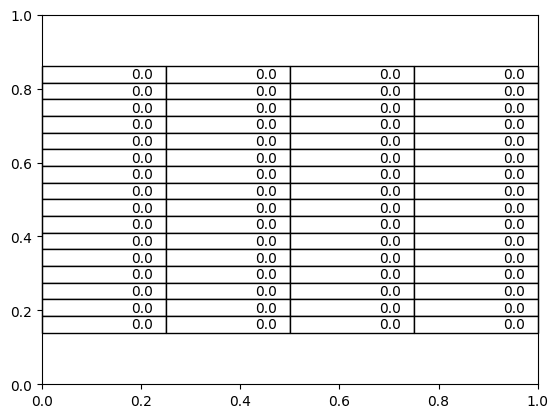

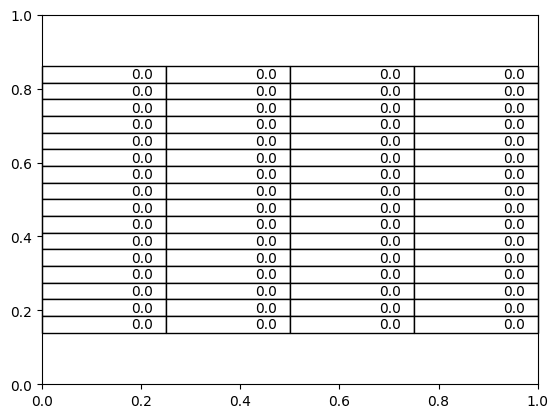

In [16]:


state_space = env.observation_space.n
action_space = env.action_space.n
print(f"state: {state_space}, action: {action_space}")

Qtable_frozenlake = np.zeros((state_space, action_space)) # create a 16 x 4 Array for the q-table
# 16x4 so it has a value for every state/action-pair
plotQtable(Qtable_frozenlake) # <=========== todo: plot anpassen mit state & action beschreibung
# each row represents a state from 0 to 15 (for a 4x4 map see variable "desc") and each column the actions right, left, up & down


## Hyperparameters

In [17]:
# Hyperparameters, finetuning will give better results

# Training parameters
n_training_episodes = 1000       # <================================== reduce for demo purpose, before: 10000
learning_rate = 0.7        

# Evaluation parameters -> number of tries from the start till termination (hole or goal)
n_eval_episodes = 100      

# Environment parameters
env_id = "FrozenLake-v1"   
max_steps = 99            
gamma = 0.95               
eval_seed = []             

# Exploration parameters
max_epsilon = 1.0           
min_epsilon = 0.05           
decay_rate = 0.0005           

### Show demo with rendering or show q-table, can't do both 

In [18]:
show_qtable=True        # if FALSE: reduce n_training_episoded to 10 or 100, 10000 will take to long/ needs to be interrupted
show_rendering= not show_qtable 

## Model Training

In [19]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
  for episode in trange(n_training_episodes):
 
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    # Reset the environment
    state = env.reset()
    if show_rendering:
      env.render()
      print(f"outer loop, episode {episode}")
    step = 0
    done = False

    # repeat
    for step in range(max_steps):
      action = epsilon_greedy_policy(Qtable, state, epsilon)

   
      new_state, reward, done, info = env.step(action)  # done value = value of start, frozen, Hole or Goal
      if show_rendering:
        print(f"inner loop, step: {step}")
        env.render()
      # time.sleep(1)
   
      Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action])
      
      # If done, finish the episode
      if done:
        # env.reset()
        # env.render()
        # time.sleep(1)
        break
     
      # Our state is the new state
      state = new_state
  if show_qtable:
    updateQtablePlot(Qtable)
  return Qtable

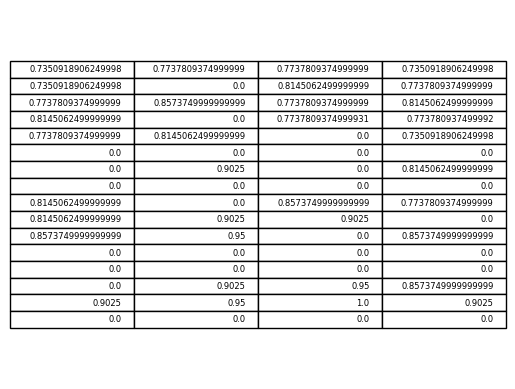

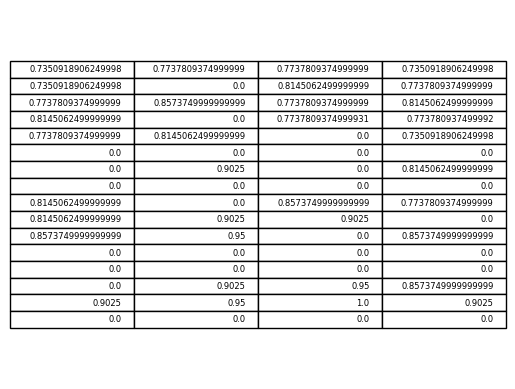

In [20]:
#BEFORE RUNNING THIS CELL -> Check if the Nr of Iteration is the one you want to prevent waiting too long/needing to interrupt
# Trains the Agent on this specific environment
Qtable_frozenlake = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_frozenlake)

### Save Q-Table to Excel

In [ ]:
pdQtable = pd.DataFrame(Qtable_frozenlake)
# pdQtable.to_Excel("Qtable_frozenlake.xlsx") # not able to append as is 
# possible todo: append strings of states and/or actions to qtable so it is labeled ni the excel
with pd.ExcelWriter('Qtable_frozenlake.xlsx',mode='a',if_sheet_exists="new") as writer: 
    pdQtable.to_excel(writer, sheet_name='Sheet375')

## Evaluation

In [ ]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):

  episode_rewards = []
  for episode in range(n_eval_episodes):
    if seed:
      state = env.reset(seed=seed[episode])
    else:
      state = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0
   
    for step in range(max_steps):
      # Take the action (index) that have the maximum reward
      action = np.argmax(Q[state][:])
      new_state, reward, done, info = env.step(action)
      total_rewards_ep += reward
       
      if done:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward